--- STEP 1: LOADING 'dataset.xlsx' ---
>> Success: Loaded 'dataset.xlsx' as Excel.
>> Total Respondents: 41
>> Groups Found: ['Tourism officer' 'NGO Staff' 'NGO staff']

       STATISTICAL ANALYSIS REPORT

[OBJECTIVE 1: Demographics]
Group
Tourism officer    20
NGO Staff          20
NGO staff           1
Name: count, dtype: int64

Sex Distribution:
Sex:
Female    21
Male      20
Name: count, dtype: int64

[OBJECTIVE 2: Roles of NGOs (Means)]
                 Role_Landslides  Role_Floods  Role_Earthquakes
Group                                                          
NGO Staff                   3.45         3.53              3.51
NGO staff                   4.00         4.00              4.00
Tourism officer             3.22         3.14              3.15

[OBJECTIVE 3: Influence on Tourism (Means)]
                 Inf_Return  Inf_Image  Inf_Rehab
Group                                            
NGO Staff              3.54       3.58       3.52
NGO staff              4.00       4.00 

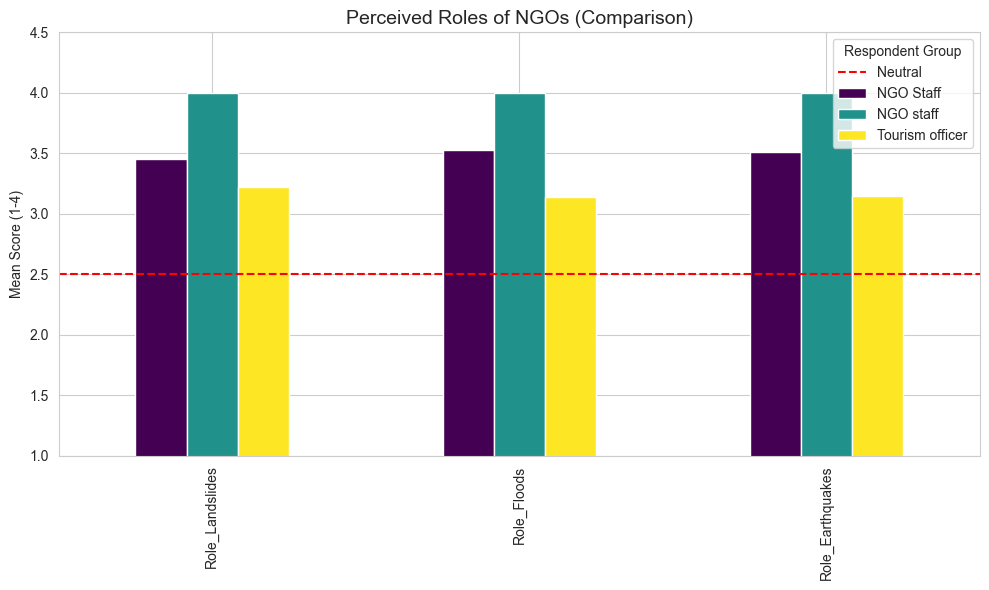

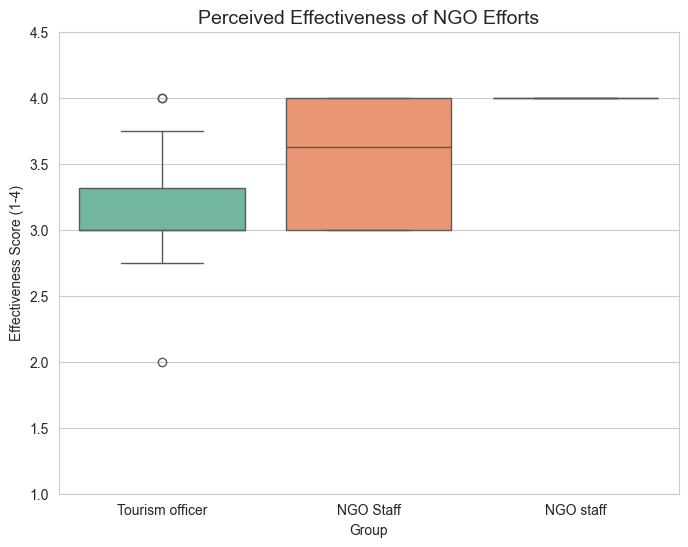

Analysis Complete.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==========================================
# 1. LOAD THE DATASET (EXCEL MODE)
# ==========================================
filename = 'dataset.xlsx'

print(f"--- STEP 1: LOADING '{filename}' ---")

try:
    # FORCE EXCEL READ
    df = pd.read_excel(filename, engine='openpyxl')
    print(f">> Success: Loaded '{filename}' as Excel.")
    print(f">> Total Respondents: {len(df)}")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load '{filename}'.")
    print(f"Details: {e}")
    # Stop execution if loading fails
    df = pd.DataFrame()

if not df.empty:
    # ==========================================
    # 2. DATA CLEANING & SCORING
    # ==========================================
    
    # Standardize columns
    df.columns = df.columns.astype(str).str.strip()

    # Define Likert Scale Map (4-Point)
    likert_map = {
        'Strongly agree': 4, 'Strongly Agree': 4,
        'Agree': 3, 'agree': 3,
        'Disagree': 2,
        'Strongly disagree': 1, 'Strongly Disagree': 1,
        'Very aware': 4, 'Very Aware': 4,
        'Moderately aware': 3, 'Moderately Aware': 3,
        'Slightly aware': 2, 'Slightly Aware': 2,
        'Not aware at all': 1, 'not aware at all': 1,
        'N/A': np.nan, 'None': np.nan, 'nan': np.nan
    }

    def score_val(x):
        if isinstance(x, (int, float)): return x
        return likert_map.get(str(x).strip(), np.nan)

    # Exclude Demographics
    demo_cols = ['Timestamp', 'Please select your respondent type:', 'Name (Optional):', 'Sex:', 
                 'Educational Attainment:', 'Occupation:', 'Length of Residency in Baguio']

    # Apply Scoring to Non-Demo Columns
    score_cols = [c for c in df.columns if c not in demo_cols]
    for col in score_cols:
        df[col] = df[col].apply(score_val)

    # --- Create Group Column ---
    # Standardize the grouping variable
    if 'Please select your respondent type:' in df.columns:
        df['Group'] = df['Please select your respondent type:']
    else:
        df['Group'] = 'Unknown'

    print(f">> Groups Found: {df['Group'].unique()}")

    # ==========================================
    # 3. COMPUTE VARIABLES (OBJECTIVES 2-4)
    # ==========================================
    
    def compute_mean(dataframe, keyword):
        cols = [c for c in dataframe.columns if keyword in c]
        if cols:
            return dataframe[cols].mean(axis=1)
        return pd.Series([np.nan] * len(dataframe))

    # Objective 2: Roles
    df['Role_Landslides'] = compute_mean(df, '2.1')
    df['Role_Floods'] = compute_mean(df, '2.2')
    df['Role_Earthquakes'] = compute_mean(df, '2.3')

    # Objective 3: Influence
    df['Inf_Return'] = compute_mean(df, '3.1')
    df['Inf_Image'] = compute_mean(df, '3.2')
    df['Inf_Rehab'] = compute_mean(df, '3.3')

    # Objective 4: Effectiveness
    df['Effectiveness'] = compute_mean(df, '4.')
    # Fallback: If Section 4 is missing, use average of Influence (Section 3)
    if df['Effectiveness'].isna().all():
        print(">> Note: Section 4 not found. Using Section 3 average as proxy for Effectiveness.")
        df['Effectiveness'] = df[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].mean(axis=1)

    # ==========================================
    # 4. STATISTICAL REPORT
    # ==========================================
    print("\n" + "="*50)
    print("       STATISTICAL ANALYSIS REPORT")
    print("="*50)

    # --- Obj 1: Demographics ---
    print("\n[OBJECTIVE 1: Demographics]")
    print(df['Group'].value_counts())
    if 'Sex:' in df.columns:
        print("\nSex Distribution:")
        print(df['Sex:'].value_counts())

    # --- Obj 2: Roles (Means) ---
    print("\n[OBJECTIVE 2: Roles of NGOs (Means)]")
    roles = df.groupby('Group')[['Role_Landslides', 'Role_Floods', 'Role_Earthquakes']].mean()
    print(roles.round(3))

    # --- Obj 3: Influence (Means) ---
    print("\n[OBJECTIVE 3: Influence on Tourism (Means)]")
    inf = df.groupby('Group')[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].mean()
    print(inf.round(3))

    # --- Obj 4: Effectiveness (Means) ---
    print("\n[OBJECTIVE 4: Perceived Effectiveness]")
    eff = df.groupby('Group')['Effectiveness'].agg(['mean', 'std', 'count'])
    print(eff.round(3))

    # --- Obj 5: Significant Difference (T-Test / ANOVA) ---
    print("\n[OBJECTIVE 5: Comparison of Perceptions]")
    
    unique_groups = df['Group'].dropna().unique()
    
    if len(unique_groups) >= 2:
        # Prepare data arrays
        groups_data = [df[df['Group'] == g]['Effectiveness'].dropna() for g in unique_groups]
        
        # Run ANOVA
        f_stat, p_val = f_oneway(*groups_data)
        
        print(f"Groups Compared: {unique_groups}")
        print(f"Test Used:       One-Way ANOVA")
        print(f"F-Statistic:     {f_stat:.4f}")
        print(f"P-Value:         {p_val:.4e}")
        
        if p_val < 0.05:
            print("Conclusion:      SIGNIFICANT DIFFERENCE exists between groups.")
        else:
            print("Conclusion:      NO SIGNIFICANT DIFFERENCE (Perceptions are similar).")
            
    else:
        print("Note: Only 1 group found. Cannot perform comparison test (T-Test/ANOVA).")

    # ==========================================
    # 5. VISUALIZATIONS
    # ==========================================
    print("\nGenerating Plots...")

    # Plot 1: Roles Bar Chart
    if not roles.empty:
        roles.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
        plt.title('Perceived Roles of NGOs (Comparison)', fontsize=14)
        plt.ylabel('Mean Score (1-4)')
        plt.ylim(1, 4.5)
        plt.axhline(2.5, color='red', linestyle='--', label='Neutral')
        plt.legend(title='Respondent Group')
        plt.tight_layout()
        plt.show()

    # Plot 2: Effectiveness Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y='Effectiveness', data=df, palette='Set2')
    plt.title('Perceived Effectiveness of NGO Efforts', fontsize=14)
    plt.ylabel('Effectiveness Score (1-4)')
    plt.ylim(1, 4.5)
    plt.show()

    print("Analysis Complete.")

else:
    print("Script halted due to loading error.")

--- STEP 1: LOADING 'dataset.xlsx' ---
>> Success: Loaded Sheet 2 (Index 1).
>> Total Respondents: 60

       TOURIST & RESIDENT ANALYSIS REPORT

[1. DEMOGRAPHIC PROFILE]
Sex Distribution:
Sex:
Female     29
Male       29
Female      2
Name: count, dtype: int64

Residency Length:
Length of Residency in Baguio
Less than 1 year      19
More than 10 years    18
1-5 years              9
less than 1 year       6
6-10 years             5
1-5 years              2
Less than 1 Year       1
Name: count, dtype: int64

Mean Awareness Level: 2.424 (1-4 Scale)

[2. PERCEIVED ROLES OF NGOs]
                   mean    std Interpretation
Role_Landslides   2.979  0.502          Agree
Role_Floods       3.014  0.494          Agree
Role_Earthquakes  3.033  0.550          Agree

[3. PERCEIVED INFLUENCE ON TOURISM]
             mean    std Interpretation
Inf_Return  3.003  0.508          Agree
Inf_Image   3.159  0.481          Agree
Inf_Rehab   3.180  0.429          Agree

[4. OVERALL EFFECTIVENESS]
Mean Sco

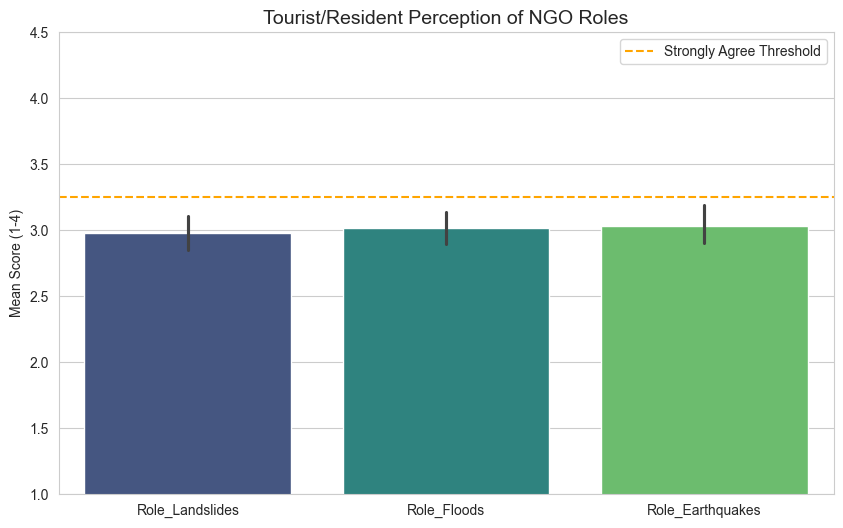

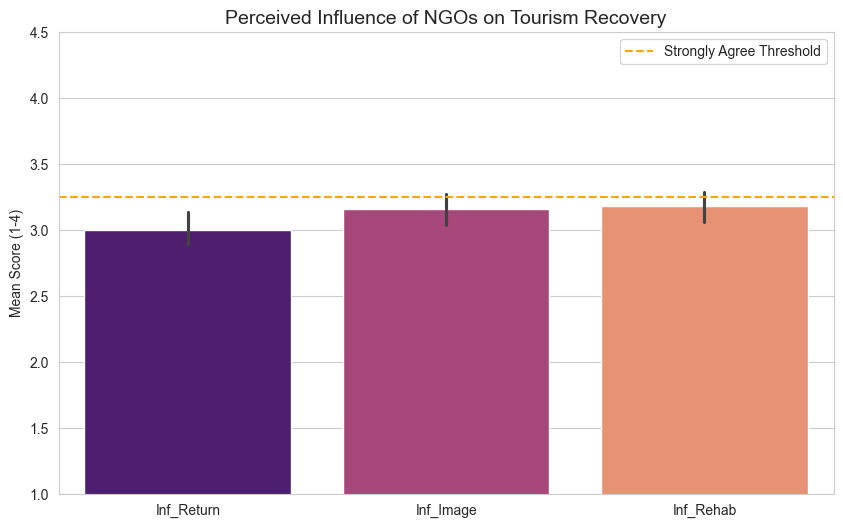

Analysis Complete.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==========================================
# 1. LOAD THE DATASET (EXCEL - SHEET 2)
# ==========================================
filename = 'dataset.xlsx'

print(f"--- STEP 1: LOADING '{filename}' ---")

try:
    # Load Sheet 2 (Index 1). If that fails, try Sheet Name "Tourist & Resident"
    # Note: sheet_name=1 loads the SECOND sheet
    try:
        df = pd.read_excel(filename, sheet_name=1, engine='openpyxl')
        print(">> Success: Loaded Sheet 2 (Index 1).")
    except:
        # Fallback: Try loading by name or just the first sheet if index fails
        try:
            df = pd.read_excel(filename, sheet_name='Tourist & Resident', engine='openpyxl')
            print(">> Success: Loaded Sheet 'Tourist & Resident'.")
        except:
            print(">> Warning: Could not find specific sheet. Loading the first sheet.")
            df = pd.read_excel(filename, sheet_name=0, engine='openpyxl')

    print(f">> Total Respondents: {len(df)}")
    
except Exception as e:
    print(f"CRITICAL ERROR: Could not load '{filename}'.")
    print(f"Details: {e}")
    df = pd.DataFrame() # Create empty DF to prevent crash

if not df.empty:
    # ==========================================
    # 2. DATA CLEANING & SCORING
    # ==========================================
    
    # Standardize columns
    df.columns = df.columns.astype(str).str.strip()

    # Likert Scale Map (4-Point)
    likert_map = {
        'Strongly agree': 4, 'Strongly Agree': 4,
        'Agree': 3, 'agree': 3,
        'Disagree': 2,
        'Strongly disagree': 1, 'Strongly Disagree': 1,
        'Very aware': 4, 'Very Aware': 4,
        'Moderately aware': 3, 'Moderately Aware': 3,
        'Slightly aware': 2, 'Slightly Aware': 2,
        'Not aware at all': 1, 'not aware at all': 1,
        'N/A': np.nan, 'None': np.nan, 'nan': np.nan
    }

    def score_val(x):
        if isinstance(x, (int, float)): return x
        return likert_map.get(str(x).strip(), np.nan)

    # Exclude Demographics
    demo_cols = ['Timestamp', 'Please select your respondent type:', 'Name (Optional):', 'Sex:', 
                 'Educational Attainment:', 'Occupation:', 'Length of Residency in Baguio']

    # Apply Scoring
    score_cols = [c for c in df.columns if c not in demo_cols]
    for col in score_cols:
        df[col] = df[col].apply(score_val)

    # ==========================================
    # 3. COMPUTE VARIABLES
    # ==========================================
    def compute_mean(dataframe, keyword):
        cols = [c for c in dataframe.columns if keyword in c]
        if cols:
            return dataframe[cols].mean(axis=1)
        return pd.Series([np.nan] * len(dataframe))

    # Objective 2: Roles (2.1, 2.2, 2.3)
    df['Role_Landslides'] = compute_mean(df, '2.1')
    df['Role_Floods'] = compute_mean(df, '2.2')
    df['Role_Earthquakes'] = compute_mean(df, '2.3')

    # Objective 3: Influence (3.1, 3.2, 3.3)
    df['Inf_Return'] = compute_mean(df, '3.1')
    df['Inf_Image'] = compute_mean(df, '3.2')
    df['Inf_Rehab'] = compute_mean(df, '3.3')

    # Objective 4: Effectiveness (Section 4)
    df['Effectiveness'] = compute_mean(df, '4.')
    if df['Effectiveness'].isna().all():
        df['Effectiveness'] = df[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].mean(axis=1)

    # Awareness Level (if column exists)
    aware_col = [c for c in df.columns if "Level of Awareness" in c]
    if aware_col:
        df['Awareness'] = df[aware_col[0]]
    else:
        df['Awareness'] = np.nan

    # ==========================================
    # 4. STATISTICAL REPORT (TOURIST & RESIDENT)
    # ==========================================
    print("\n" + "="*50)
    print("       TOURIST & RESIDENT ANALYSIS REPORT")
    print("="*50)

    # --- 1. Demographics ---
    print("\n[1. DEMOGRAPHIC PROFILE]")
    if 'Sex:' in df.columns:
        print("Sex Distribution:")
        print(df['Sex:'].value_counts())
    
    if 'Length of Residency in Baguio' in df.columns:
        print("\nResidency Length:")
        print(df['Length of Residency in Baguio'].value_counts())

    if 'Awareness' in df.columns:
        print(f"\nMean Awareness Level: {df['Awareness'].mean():.3f} (1-4 Scale)")

    # --- 2. Roles of NGOs ---
    print("\n[2. PERCEIVED ROLES OF NGOs]")
    roles_stats = df[['Role_Landslides', 'Role_Floods', 'Role_Earthquakes']].describe().T
    roles_stats['Interpretation'] = roles_stats['mean'].apply(lambda x: "Strongly Agree" if x>=3.25 else ("Agree" if x>=2.5 else "Disagree"))
    print(roles_stats[['mean', 'std', 'Interpretation']].round(3))

    # --- 3. Influence ---
    print("\n[3. PERCEIVED INFLUENCE ON TOURISM]")
    inf_stats = df[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].describe().T
    inf_stats['Interpretation'] = inf_stats['mean'].apply(lambda x: "Strongly Agree" if x>=3.25 else ("Agree" if x>=2.5 else "Disagree"))
    print(inf_stats[['mean', 'std', 'Interpretation']].round(3))

    # --- 4. Effectiveness ---
    print("\n[4. OVERALL EFFECTIVENESS]")
    eff_mean = df['Effectiveness'].mean()
    eff_std = df['Effectiveness'].std()
    eff_interp = "Very Effective" if eff_mean >= 3.25 else ("Effective" if eff_mean >= 2.5 else "Ineffective")
    
    print(f"Mean Score: {eff_mean:.3f}")
    print(f"Std Dev:    {eff_std:.3f}")
    print(f"Rating:     {eff_interp}")

    # ==========================================
    # 5. VISUALIZATIONS
    # ==========================================
    print("\nGenerating Plots...")

    # Plot 1: Roles Bar Chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[['Role_Landslides', 'Role_Floods', 'Role_Earthquakes']], palette='viridis')
    plt.title('Tourist/Resident Perception of NGO Roles', fontsize=14)
    plt.ylabel('Mean Score (1-4)')
    plt.ylim(1, 4.5)
    plt.axhline(3.25, color='orange', linestyle='--', label='Strongly Agree Threshold')
    plt.legend()
    plt.show()

    # Plot 2: Influence Bar Chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[['Inf_Return', 'Inf_Image', 'Inf_Rehab']], palette='magma')
    plt.title('Perceived Influence of NGOs on Tourism Recovery', fontsize=14)
    plt.ylabel('Mean Score (1-4)')
    plt.ylim(1, 4.5)
    plt.axhline(3.25, color='orange', linestyle='--', label='Strongly Agree Threshold')
    plt.legend()
    plt.show()

    print("Analysis Complete.")

else:
    print("Error: DataFrame is empty. Check file path or content.")

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Filename
filename = 'dataset.xlsx'

print(f"--- ANALYZING DEMOGRAPHICS FROM '{filename}' ---")

# Load both sheets
try:
    # Try loading Sheet 1 (NGO/Officer) and Sheet 2 (Tourist/Resident)
    # Note: openpyxl engine is needed for xlsx
    xls = pd.ExcelFile(filename, engine='openpyxl')
    print(f"Sheet names found: {xls.sheet_names}")
    
    df_list = []
    
    for sheet in xls.sheet_names:
        try:
            d = pd.read_excel(xls, sheet_name=sheet)
            # Add a column for the source sheet to keep track of groups if needed
            d['Source_Sheet'] = sheet
            df_list.append(d)
        except Exception as e:
            print(f"Error loading sheet '{sheet}': {e}")
            
    if df_list:
        df_all = pd.concat(df_list, ignore_index=True)
        print(f"Total Combined Respondents: {len(df_all)}")
        
        # Clean columns
        df_all.columns = df_all.columns.astype(str).str.strip()
        
        # Identify Demographic Columns based on the user's list
        # 1.1 Age
        # 1.2 Sex
        # 1.3 Educational attainment
        # 1.4 Occupation
        # 1.5 Length of residency
        # 1.6 Level of awareness
        
        # Helper to find column by keyword
        def find_col(df, keywords):
            for col in df.columns:
                if any(k.lower() in col.lower() for k in keywords):
                    return col
            return None

        col_age = find_col(df_all, ['age'])
        col_sex = find_col(df_all, ['sex', 'gender'])
        col_edu = find_col(df_all, ['educational', 'attainment'])
        col_occ = find_col(df_all, ['occupation', 'work', 'job'])
        col_res = find_col(df_all, ['residency', 'how long'])
        col_awa = find_col(df_all, ['awareness', 'level of awareness'])
        col_type = find_col(df_all, ['respondent type'])

        print("\n--- 1. DEMOGRAPHIC CHARACTERISTICS ---")
        
        # 1.1 Age
        if col_age:
            print(f"\n[1.1 AGE] (Column: {col_age})")
            print(df_all[col_age].value_counts(dropna=False))
        else:
            print("\n[1.1 AGE] - Column NOT FOUND in dataset.")

        # 1.2 Sex
        if col_sex:
            print(f"\n[1.2 SEX] (Column: {col_sex})")
            print(df_all[col_sex].value_counts(dropna=False))
        else:
            print("\n[1.2 SEX] - Column NOT FOUND.")

        # 1.3 Educational Attainment
        if col_edu:
            print(f"\n[1.3 EDUCATIONAL ATTAINMENT] (Column: {col_edu})")
            print(df_all[col_edu].value_counts(dropna=False))
        else:
            print("\n[1.3 EDUCATIONAL ATTAINMENT] - Column NOT FOUND.")

        # 1.4 Occupation
        if col_occ:
            print(f"\n[1.4 OCCUPATION] (Column: {col_occ})")
            print(df_all[col_occ].value_counts(dropna=False))
        else:
            print("\n[1.4 OCCUPATION] - Column NOT FOUND.")

        # 1.5 Length of Residency
        if col_res:
            print(f"\n[1.5 LENGTH OF RESIDENCY] (Column: {col_res})")
            print(df_all[col_res].value_counts(dropna=False))
        else:
            print("\n[1.5 LENGTH OF RESIDENCY] - Column NOT FOUND.")

        # 1.6 Level of Awareness
        if col_awa:
            print(f"\n[1.6 LEVEL OF AWARENESS] (Column: {col_awa})")
            # Calculate mean if numeric-ish (1-4), or counts if categorical text
            # The previous analysis showed it has text like "Very aware", "Slightly aware"
            print(df_all[col_awa].value_counts(dropna=False))
            
            # Try to map to numbers for a mean score
            map_aware = {
                'Very aware': 4, 'Very Aware': 4,
                'Moderately aware': 3, 'Moderately Aware': 3,
                'Slightly aware': 2, 'Slightly Aware': 2,
                'Not aware at all': 1, 'not aware at all': 1
            }
            numeric_aware = df_all[col_awa].map(map_aware)
            if not numeric_aware.isna().all():
                print(f"Mean Awareness Score: {numeric_aware.mean():.3f}")
        else:
            print("\n[1.6 LEVEL OF AWARENESS] - Column NOT FOUND.")

    else:
        print("No data found in sheets.")

except Exception as e:
    print(f"Error processing file: {e}")

--- ANALYZING DEMOGRAPHICS FROM 'dataset.xlsx' ---
Sheet names found: ['NGO & Tourism Officer', 'Tourist & Resident']
Total Combined Respondents: 101

--- 1. DEMOGRAPHIC CHARACTERISTICS ---

[1.1 AGE] (Column: 2.2 Floods [5. I feel motivated to support long-term flood mitigation efforts such as drainage improvement or community education.])
2.2 Floods [5. I feel motivated to support long-term flood mitigation efforts such as drainage improvement or community education.]
NaN                  60
Agree                20
Strongly Agree       18
Strongly agree        2
Strongly Disagree     1
Name: count, dtype: int64

[1.2 SEX] (Column: Sex:)
Sex:
Female     50
Male       49
Female      2
Name: count, dtype: int64

[1.3 EDUCATIONAL ATTAINMENT] (Column: Educational Attainment:)
Educational Attainment:
College / Undergraduate Studies    52
College/ Undergraduate             15
College / Undergraduate            15
High School or below                6
Vocational / Technical Course       5
Hi

In [7]:
import pandas as pd
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. LOAD DATA FROM EXCEL SHEETS
# ==========================================
filename = 'dataset.xlsx'

print(f"--- STEP 1: LOADING '{filename}' ---")

try:
    # Load Sheet 1 (Index 0) -> Tourist & Resident
    # Note: Adjust sheet_name='Sheet1' if your tabs have specific names, or use index 0
    df_tourist = pd.read_excel(filename, sheet_name=0, engine='openpyxl')
    print(f">> Success: Loaded Tourist Data (N={len(df_tourist)})")

    # Load Sheet 2 (Index 1) -> NGO & Tourism Officer
    # Note: Adjust sheet_name='Sheet2' if your tabs have specific names, or use index 1
    df_ngo = pd.read_excel(filename, sheet_name=1, engine='openpyxl')
    print(f">> Success: Loaded NGO Data (N={len(df_ngo)})")

except Exception as e:
    print(f"CRITICAL ERROR: Could not load '{filename}'.")
    print(f"Details: {e}")
    # Create empty DFs to prevent the rest of the script from crashing immediately
    df_tourist = pd.DataFrame()
    df_ngo = pd.DataFrame()

# ==========================================
# 2. DEMOGRAPHIC ANALYSIS FUNCTION
# ==========================================
def analyze_demographics(df, group_name):
    print(f"\n==================================================")
    print(f"   ANALYSIS FOR GROUP: {group_name}")
    print(f"==================================================")

    if df.empty:
        print("Dataframe is empty. Skipping...")
        return

    # Clean column names
    df.columns = df.columns.astype(str).str.strip()

    # Helper function to find and print distribution
    def print_dist(keywords, title):
        # Find column that matches any keyword
        found_cols = [c for c in df.columns if any(k in c.lower() for k in keywords)]
        
        # Filter logic to avoid picking long survey questions instead of demographic labels
        # Demographic columns are usually short (e.g., "Sex", "Age")
        # We pick the shortest match, unless it's "Awareness" where we need "Level of Awareness"
        valid_cols = []
        for col in found_cols:
            if "level of awareness" in title.lower():
                 if "level" in col.lower() and "aware" in col.lower(): valid_cols.append(col)
            else:
                 valid_cols.append(col)
        
        if not valid_cols:
            # Fallback: simple search
             valid_cols = found_cols

        if valid_cols:
            # Pick the shortest column name as it's likely the header
            target_col = min(valid_cols, key=len)
            
            print(f"\n[{title}] (Column: {target_col})")
            
            # Get counts
            counts = df[target_col].value_counts().sort_index()
            total = len(df[target_col].dropna())
            
            print(f"{'Category':<40} {'Frequency':<10} {'Percentage'}")
            print("-" * 65)
            for cat, freq in counts.items():
                pct = (freq / total) * 100
                print(f"{str(cat):<40} {freq:<10} {pct:.1f}%")
            
            # Special logic for Awareness Mean Score
            if "awareness" in title.lower():
                likert_map = {
                    'Very aware': 4, 'Very Aware': 4,
                    'Moderately aware': 3, 'Moderately Aware': 3,
                    'Slightly aware': 2, 'Slightly Aware': 2,
                    'Not aware at all': 1, 'not aware at all': 1
                }
                # Map values
                numeric_scores = df[target_col].map(lambda x: likert_map.get(str(x).strip(), np.nan))
                mean_score = numeric_scores.mean()
                print(f"Mean Score: {mean_score:.3f}")
        else:
            print(f"\n[{title}] -> Column Not Found")

    # Run analysis for specific demographic variables
    # 1.1 Age (often missing in these datasets, but we check)
    print_dist(['age'], '1.1 Age')
    
    # 1.2 Sex
    print_dist(['sex'], '1.2 Sex')
    
    # 1.3 Education
    print_dist(['education', 'attainment'], '1.3 Educational Attainment')
    
    # 1.4 Occupation
    print_dist(['occupation'], '1.4 Occupation')
    
    # 1.5 Residency
    print_dist(['residen'], '1.5 Length of Residency')
    
    # 1.6 Awareness
    print_dist(['aware'], '1.6 Level of Awareness')

# ==========================================
# 3. EXECUTE ANALYSIS
# ==========================================
analyze_demographics(df_tourist, "TOURISTS & RESIDENTS")
analyze_demographics(df_ngo, "NGO STAFF & TOURISM OFFICERS")

--- STEP 1: LOADING 'dataset.xlsx' ---
>> Success: Loaded Tourist Data (N=41)
>> Success: Loaded NGO Data (N=60)

   ANALYSIS FOR GROUP: TOURISTS & RESIDENTS

[1.1 Age] (Column: 2.3 Earthquakes [3. I am interested in joining restoration efforts for damaged tourist attractions or tourism facilities.])
Category                                 Frequency  Percentage
-----------------------------------------------------------------
Agree                                    28         68.3%
Disagree                                 1          2.4%
Strongly Agree                           11         26.8%
Strongly agree                           1          2.4%

[1.2 Sex] (Column: Sex:)
Category                                 Frequency  Percentage
-----------------------------------------------------------------
Female                                   21         51.2%
Male                                     20         48.8%

[1.3 Educational Attainment] (Column: Educational Attainment:)
Cate

                                     Return of Tourists  Destination Image  \
Please select your respondent type:                                          
Community Resident                                3.640           4.057143   
Tourist                                           4.064           4.048000   

                                     Rehab of Attractions  
Please select your respondent type:                        
Community Resident                               4.034286  
Tourist                                          4.184000  


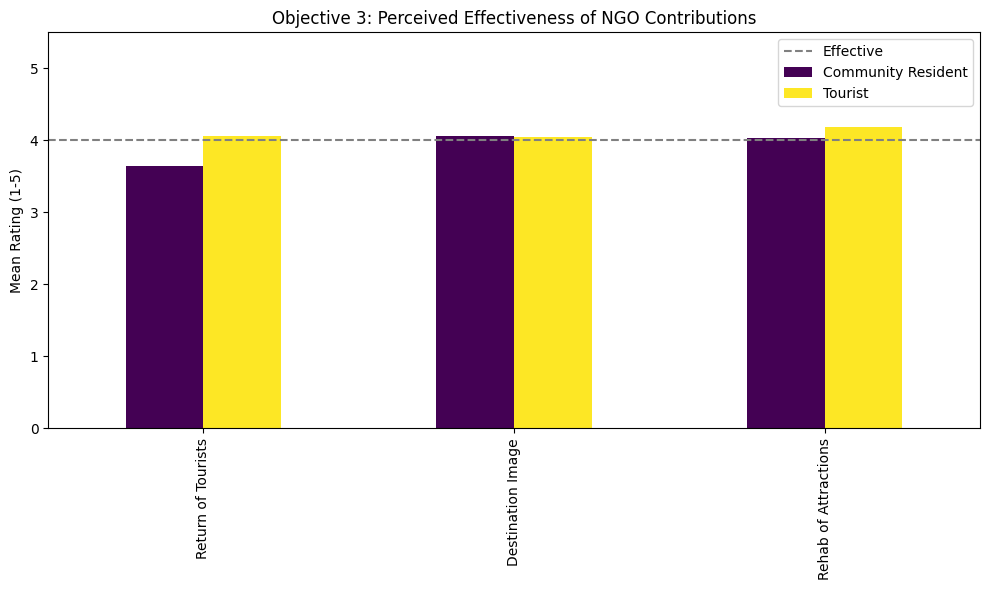

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the dataset (Handling Encoding)
try:
    df = pd.read_csv("dataset(Tourist & Resident).csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("dataset(Tourist & Resident).csv", encoding='ISO-8859-1')

# 2. FIX: Clean the 'Respondent Type' column to remove extra spaces
# This merges "Tourist " and "Tourist" into one group
respondent_col = 'Please select your respondent type:'
df[respondent_col] = df[respondent_col].str.strip()

# 3. Identify Objective 3 columns (Section 3.x)
obj3_cols = [col for col in df.columns if col.startswith("3.")]

# 4. Define Likert scale mapping
likert_map = {
    'strongly agree': 5,
    'agree': 4,
    'neutral': 3,
    'neither agree nor disagree': 3,
    'undecided': 3,
    'disagree': 2,
    'strongly disagree': 1
}

def clean_and_map(val):
    if isinstance(val, str):
        val = val.lower().strip()
        if 'not' in val and 'aware' in val: return np.nan
        return likert_map.get(val, np.nan)
    return np.nan

# 5. Apply mapping
df_obj3 = df.copy()
for col in obj3_cols:
    df_obj3[col] = df_obj3[col].apply(clean_and_map)

# 6. Calculate composite means
df_obj3['Mean_3.1'] = df_obj3[[c for c in obj3_cols if c.startswith("3.1")]].mean(axis=1)
df_obj3['Mean_3.2'] = df_obj3[[c for c in obj3_cols if c.startswith("3.2")]].mean(axis=1)
df_obj3['Mean_3.3'] = df_obj3[[c for c in obj3_cols if c.startswith("3.3")]].mean(axis=1)

# 7. Group and Plot
grouped = df_obj3.groupby(respondent_col)[['Mean_3.1', 'Mean_3.2', 'Mean_3.3']].mean()
grouped.columns = ['Return of Tourists', 'Destination Image', 'Rehab of Attractions']

print(grouped)

ax = grouped.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Objective 3: Perceived Effectiveness of NGO Contributions')
plt.ylabel('Mean Rating (1-5)')
plt.ylim(0, 5.5)
plt.axhline(y=4, color='gray', linestyle='--', label='Effective')
plt.legend()
plt.tight_layout()
plt.savefig('objective_3_corrected.png')